## <center>Predicción de renuncia de clientes

1. Importa las librerías necesarias para aplicar preprocesamiento de datos,
visualización y creación de un modelo de red neuronal feedforward con Keras y
Tensorflow. Importa la base de datos Customer Churn.csv y realiza 
preprocesamiento de los datos.

In [14]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD # Gradiente Descendente estocástico

# Cargar el conjunto de datos
df = pd.read_csv('Customer Churn.csv')

# Ver las primeras filas del dataset
print(df.head())



   Call  Failure  Complains  Subscription  Length  Charge  Amount  ...  Status  Age  Customer Value  Churn
0              8          0                    38               0  ...       1   30         197.640      0
1              0          0                    39               0  ...       2   25          46.035      0
2             10          0                    37               0  ...       1   30        1536.520      0
3             10          0                    38               0  ...       1   15         240.020      0
4              3          0                    38               0  ...       1   15         145.805      0

[5 rows x 14 columns]


1. **Call Failures**: Número de fallos de llamadas
2. **Complaints**: Quejas (1) o ninguna queja (0)
3. **Subscription Length**: Meses totales de suscripción
4. **Charge Amount**: Importe del cargo, atributo ordinal (0: importe más bajo, 9: importe más alto)
5. **Seconds of Use**: Segundos totales de llamadas
6. **Frequency of use**: Número total de llamadas
7. **Frequency of SMS**: Número total de mensajes de texto
8. **Distinct Called Numbers**: Número total de llamadas distintas
9. **Age Group**: Grupo de edad, atributo ordinal (1: menor edad, 5: mayor edad)
10. **Tariff Plan**: Plan de tarifa, binario (1: pago por uso, 2: contractual)
11. **Status**: Estado, binario (1: activo, 2: inactivo)
12. **Customer Value**: El valor calculado del cliente

**Churn: Renuncia, binario (1: cancelación, 0: no cancelación) - Etiqueta de clase**


In [2]:
# Mostrar información general
display(df.head())
display(df.info())
display(df.describe())

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

None

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


In [5]:
# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

# Verificar si hay valores nulos
print(df.isnull().sum())

# Eliminar filas con valores nulos (si los hay)
df = df.dropna()

# Separar las características (X) y la etiqueta (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Estandarizar las variables regresoras
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64


2. Análisis de la distribución de "Subscription Length"
Ahora, analizamos la distribución de "Subscription Length" para cada clase (Churn).

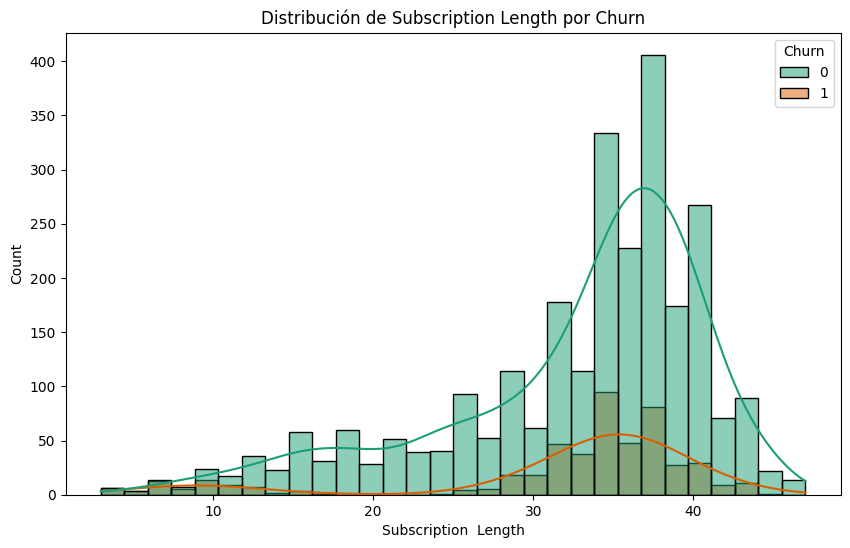

In [6]:
# Analizar la distribución de "Subscription Length" para cada clase
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Subscription  Length', hue='Churn', kde=True,bins=30, palette='Dark2')
plt.title('Distribución de Subscription Length por Churn')
plt.show()

3. Balanceo de clases y división del conjunto de datos
A continuación, mostramos la frecuencia de cada clase y realizamos un balanceo de clases usando SMOTE. Luego, dividimos el conjunto de datos en entrenamiento y test.

In [10]:
# Mostrar la frecuencia de cada clase
print(y.value_counts())

smote = SMOTE(random_state=1223)

# Balancear las clases usando SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Dividir el conjunto de datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

Churn
0    2655
1     495
Name: count, dtype: int64


In [11]:
y_resampled.value_counts()

Churn
0    2655
1    2655
Name: count, dtype: int64

4. Entrenar un modelo RandomForest y mostrar métricas
Entrenamos un modelo RandomForest con hiperparámetros por defecto y mostramos la métrica F1-Score para ambas clases en el conjunto de test. Además, capturamos y mostramos las siete características más importantes detectadas por el modelo.

In [12]:
# Entrenar un modelo RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predecir en el conjunto de test
y_pred = rf_model.predict(X_test)

# Mostrar la métrica F1-Score para ambas clases
f1 = f1_score(y_test, y_pred, average=None)
print(f'F1-Score para cada clase: {f1}')

# Mostrar las siete características más importantes
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-7:]
print('Características más importantes:')
for i in indices:
    print(df.columns[i])

F1-Score para cada clase: [0.97365407 0.97386364]
Características más importantes:
Distinct Called Numbers
Customer Value
Subscription  Length
Seconds of Use
Complains
Frequency of use
Status


Alto rendimiento del modelo: El F1-Score para cada clase es muy alto (~0.97)

Características más relevantes:
El modelo parece basarse en características clave del comportamiento del cliente, como la cantidad de números distintos llamados (Distinct Called Numbers), el valor del cliente (Customer Value) y la duración de la suscripción (Subscription Length). Esto sugiere que el modelo captura patrones significativos en los datos.

5. Entrenar un modelo de red neuronal feedforward
Finalmente, usando las siete características más importantes, filtramos el conjunto de entrenamiento y entrenamos un modelo de red neuronal feedforward con una capa oculta. Ajustamos manualmente los hiperparámetros para lograr un AUC mayor al 90%.

In [16]:
print(X_train_filtered.shape)


(3557, 7)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.8079 - loss: 0.6361 - val_AUC: 0.8974 - val_loss: 0.5202
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9087 - loss: 0.5018 - val_AUC: 0.9054 - val_loss: 0.4529
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9018 - loss: 0.4495 - val_AUC: 0.9080 - val_loss: 0.4175
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9179 - loss: 0.4116 - val_AUC: 0.9120 - val_loss: 0.3963
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9255 - loss: 0.3817 - val_AUC: 0.9133 - val_loss: 0.3826
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9233 - loss: 0.3754 - val_AUC: 0.9147 - val_loss: 0.3731
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9221 - loss: 0.3658 - val_AUC: 0.9152 - val_loss: 0.3661
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9180 - loss: 0.3674 - val_AUC: 0.9156 - val_loss: 0.3607
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9292 - loss: 

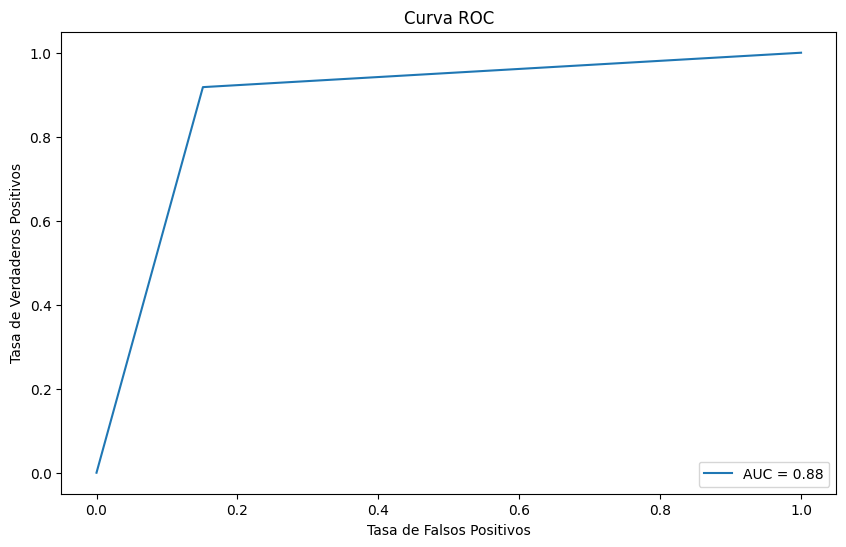

In [17]:
# Filtrar el conjunto de entrenamiento con las siete características más importantes
X_train_filtered = X_train[:, indices]
X_test_filtered = X_test[:, indices]

# Definir el modelo de red neuronal
model = Sequential([
    Input(shape=(7,)),  # capa de entrada
    Dense(64, activation='relu'),#capa oculta
    Dense(1, activation='sigmoid')# Capa de salida
]) 

# Compilar el modelo
sgd = SGD(learning_rate=0.01) # Gradiente Descendente estocástico
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['AUC'])

# Entrenar el modelo
history = model.fit(X_train_filtered, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predecir en el conjunto de test
y_pred_nn = model.predict(X_test_filtered)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

# Calcular el AUC
auc = roc_auc_score(y_test, y_pred_nn)
print(f'AUC: {auc}')

# Mostrar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nn)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

En la parte inicial de la curva (baja tasa de falsos positivos), el modelo identifica correctamente muchos verdaderos positivos, lo que es ideal.
Conforme aumenta la tasa de falsos positivos, también crece la tasa de verdaderos positivos, lo que sugiere que el modelo mantiene un buen equilibrio.
